In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
import math 
import qutip as qt
from scipy.optimize import curve_fit

from scipy.stats import norm

import scipy.integrate as integrate

from scipy.signal import argrelextrema #Til opgave 2a
import seaborn

# local imports
from simulate_von_neumann import *

# set theme
seaborn.set_style('ticks')


seaborn.set(font_scale=1.25)

%reload_ext autoreload 
%autoreload 2


# The von Neumann model

In this worksheet we will investigate weak measurement with a qubit system and a free particle as a meter. The hamiltonian is 

$$H=H_s+ H_M  + H_{SM} = \frac{\epsilon}{2} \hat{\sigma}_z \otimes \mathbf{1}+ \mathbf{1}\otimes \frac{\hat{p}^2}{2m} + g \delta(t)\hat{\sigma}_z \otimes \hat{p}$$

The system is analogue to light passing trough a birefringent crystal or a spin 1/2 particle in a single Stern Gerlach experiment. The meter system is treated as a photographic plate but the gaussian wave function is also common in more technical measurement devises like a quantum point contact. We first introduce the theoretical predictions learned from the Quantum Measurement book and thereafter the simulate the system using the stochastic master equation. 


## Theoretical overview

The state of the whole system is a direct product of the system state and the meter state $\ket{\Psi}=\ket{\psi}_S\otimes \ket{\phi}_M$. Instead of the classical collapse of a wave function using projective measurement, we have a partial collapse where it is only the meter that collapses to a state $\ket{x}_M$. Using the Heisenberg picture the state immediatly after the delta interaction at $t=0$ is 

$$\ket{\tilde{\Psi}}= \hat{U}_{SM}\ket{\tilde{\psi}}_S\otimes \ket{\tilde{\phi}}_M  = \exp(-ig\hat{\sigma}_z \otimes \hat{p}/\hbar)\ket{\tilde{\psi}}_S\otimes \ket{\tilde{\phi}}_M$$

Writing in terms of the basis of the system hamiltonian and recognizing the translation operator we get a measurement operator 

$$\Omega_x \equiv _M\langle x \mid \hat{U}_{SM} \ket{\tilde{\phi}}_M = \mid + \rangle_S \langle + \mid \phi(x-g) + \mid - \rangle_S \langle - \mid \phi(x+g)$$

Where the $\phi(x)$ is the position representation of the meter state:

$$\phi(x)=\braket{x \mid\phi} = \frac{1}{(2\pi \sigma^2)^{1/2}} \exp(-\frac{x^2}{4\sigma^2})$$

But through measurement $\braket{x \mid\phi} = \delta (t)$ right...? For measurement outcome $x$ the particle starting in  $\ket{\tilde{\psi}}=a\ket{+}+b\ket{-}$ is in state

$$P_x = \mid \mid \Omega_x \ket{\psi} \mid \mid^2$$
The meter starts in a eigenstate of the system $\phi(x)$ which is a gausian with center at the origin. The post measurement state will collaps the meter to the value $x$ and the system state s 

$$\ket{\psi'}= \frac{\Omega_x \ket{\psi}}{\mid \mid \Omega_x \ket{\psi} \mid \mid}$$

From the initial value of the system:

$$\ket{\tilde{\psi}}_S=a\ket{+}+b\ket{+}$$

$$\rho_{j+1}=\sum_x\Omega_x \ket{\psi_j}\bra{\psi_j}\Omega_x^{\dagger} $$

Does the coeficients here depend of time...? They most have some wiggle factor

$$\ket{\tilde{\psi}}_S=\mathrm{e}^{-iH_st}(a_0\ket{+}+b_0\ket{-})$$

We assign any complex value on a, since any complex value of b can be wewritten from the freedom of a global phase


In [2]:
#Initial parameters for system and meter  
a0 = 1#1/(np.sqrt(2))+0j #system initial coefficient plus polarized 
b0 = np.sqrt(1-abs(a0)**2)#1/(np.sqrt(2)) #system initial coefficient mins polarized 
sigma = 1 #standard deviation of meter's initial wave function

X_span = np.linspace(-10,10,250)

gstrong = sigma*4 #much bigger than deviation of position 
gweak = sigma/4 #much bigger than deviation of position 



exp_x_strong = integrate.quad(lambda x: x*p(x,gstrong,a0,b0), -10, 10)[0]
exp_x_weak = integrate.quad(lambda x: x*p(x,gweak,a0,b0), -10, 10)[0]


#print(f"normalization: {exp_x_weak}, {exp_x_strong}")


<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\l'
C:\Users\kts661\AppData\Local\Temp\ipykernel_26788\3959874226.py:5: SyntaxWarning: invalid escape sequence '\g'
  ax[0,0].set_title(f'Strong int. ($g\gg\sigma$)')
C:\Users\kts661\AppData\Local\Temp\ipykernel_26788\3959874226.py:21: SyntaxWarning: invalid escape sequence '\l'
  ax[0,1].set_title(f'Weak int ($g\ll\sigma$)')


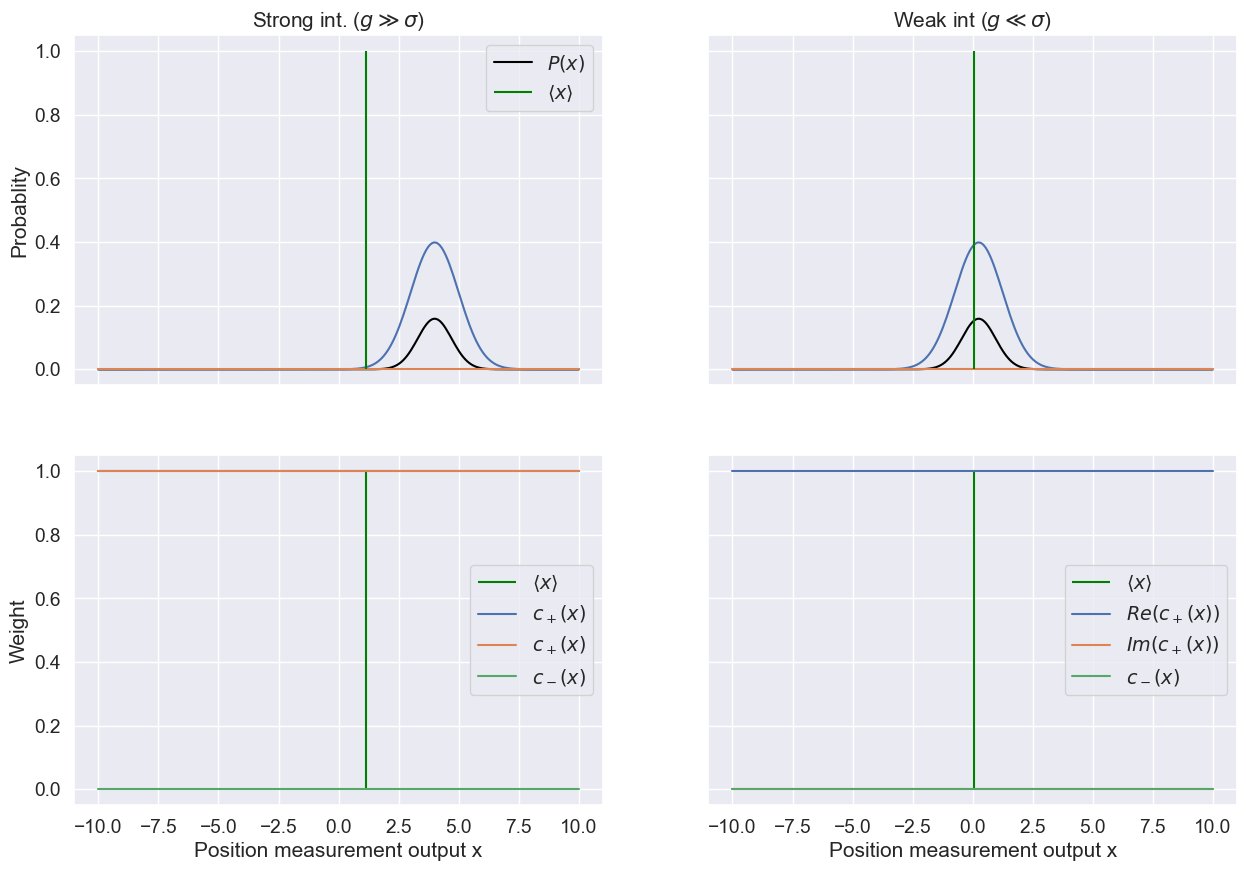

In [3]:
fig,ax = plt.subplots(2,2,sharex=True,sharey=True,figsize=(15,10))

# set figsize

ax[0,0].set_title(f'Strong int. ($g\gg\sigma$)')
ax[0,0].plot(X_span,p(X_span,gstrong,a0,b0),color='Black',label=f'$P(x)$')
ax[0,0].plot(X_span,a0*phi(X_span-gstrong))
ax[0,0].plot(X_span,b0*phi(X_span+gstrong))
ax[0,0].vlines(exp_x_strong,0,1,label=r'$\langle x \rangle$',color='green')
ax[1,0].vlines(exp_x_strong,0,1,label=r'$\langle x \rangle$',color='green')

ax[1,0].plot(X_span,cplus_VN(X_span,gstrong,a0,b0),label = f'$c_+(x)$')
ax[1,0].plot(X_span,cplus_VN(X_span,gstrong,a0,b0),label = f'$c_+(x)$')
ax[1,0].plot(X_span,cminus_VN(X_span,gstrong,a0,b0),label = f'$c_-(x)$')

ax[1,0].set_xlabel('Position measurement output x')

ax[0,0].legend()
ax[1,0].legend()

ax[0,1].set_title(f'Weak int ($g\ll\sigma$)')
ax[0,1].plot(X_span,p(X_span,gweak,a0,b0),color='Black')
ax[0,1].plot(X_span,a0.real*phi(X_span-gweak))
ax[0,1].plot(X_span,a0.imag*phi(X_span-gweak),color='pink')
ax[0,1].plot(X_span,b0.real*phi(X_span+gweak))

ax[0,1].vlines(exp_x_weak,0,1,label=r'$\langle x \rangle$',color='green')
ax[1,1].vlines(exp_x_weak,0,1,label=r'$\langle x \rangle$',color='green')

ax[1,1].plot(X_span,cplus_VN(X_span,gweak,a0,b0),label = f'$Re(c_+(x))$')
ax[1,1].plot(X_span,cplus_VN(X_span,gweak,a0,b0).imag,label = f'$Im(c_+(x))$')
ax[1,1].plot(X_span,cminus_VN(X_span,gweak,a0,b0),label = f'$c_-(x)$')

ax[0,0].set_ylabel('Probablity')
ax[1,0].set_ylabel('Weight')
ax[1,1].set_xlabel('Position measurement output x')


ax[1,1].legend()
plt.show()

Now the the simulaton we want to see the dynamics of a measurements, say the expectationvalue of x $\exp{x(t)}$. But since the system hamiltonian commutes with the interaction term, any measurement of the system will not change the state of the system - it is a . Two sequential measurements have the same possible measurement outcome as a single measurement. We therefore expect the expectation value of the position is constant:

In [4]:
#sanity check: integrate.quad(lambda x: p(x,gstrong,a,b), -10, 10)

## Random walk simulation using wavefunction (not mixed state) 

Now we will have multiple sequential measurements of the system, like having severial identical stern gerlach experiements/birefringent crystals. We take $N$ measurements with $\Delta t$ time inbetween each measurement. The i'th time step (with a weak measurement) will give us:

* Time step $t_j = t_{j-1}+\Delta t$
* Position measurement $x_i$ taken from the distribution $P(x,a_{i-1},b_{i-1})$.
* Post measurement state, by updating the coeficitens $$\ket{\psi_{j+1}}= \frac{\Omega_x \ket{\psi_j}}{\mid \mid \Omega_x \ket{\psi_j} \mid \mid}$$

Which ultimately will give us 3 lists $\{x_i\}, \{a_i\}, \{b_i\}$ through a time evolution t.  





We *can* a Weiner process from a gausian - might not be important since we already draw x from a gaussian, but it might give a nice way to learn how to include other noise? 


In [ ]:
N = 150 #Number of measurements per simulation
epsilon = 0
delta_t = 1 #time between each measurement, relative to system evolution (compare with epsiplon)
t_span = np.linspace(0,delta_t*N,N+1)

r= 0 #Successrate for measurement (Therefore also ONLY measurement record !) 

N_sim = 500 #number of simulations

In [ ]:
def U_z(epsilon=epsilon, delta_t=delta_t):
    return np.array([[np.exp(-1j*epsilon*delta_t),0],[0,np.exp(1j*epsilon*delta_t)]])

def U_x(epsilon=epsilon, delta_t=delta_t):
    return np.array([[np.cos(epsilon*delta_t),-1j*np.sin(epsilon*delta_t)],
                     [-1j*np.sin(epsilon*delta_t),np.cos(epsilon*delta_t)]])

#We could also include dynamics that depends on t = delta_t*n where n<= N.

np.complex128(1+0j)

In [10]:
np.repeat(0,19)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
U_z(epsilon, delta_t)

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

Kan du omformulere din lindblad master equation til at være fra ændringern af din measurement record dx istedet for dt. 

Evt benytte controllet differential equation

Now running N_sim simulations, calibrated so we see a steady state solution

In [16]:
X_ensembe_weak,a_ensembe_weak, b_ensembe_weak,m_error_weak = Xeuler_sim(N_sim, N,gweak, U_x(epsilon=epsilon, delta_t=delta_t), a0, b0)  #X_sim(N_sim,N,gweak,a0=a0,b0=b0)
X_ensembe_strong,a_ensembe_strong, b_ensembe_strong,m_error_strong = Xeuler_sim(N_sim,N,gstrong, U_x(epsilon=epsilon, delta_t=delta_t), a0,b0,1)


Now the strong is not that interesting. 

In [15]:
m_error_weak

array([[0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       ...,
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.],
       [0., 1., 1., ..., 1., 1., 1.]])

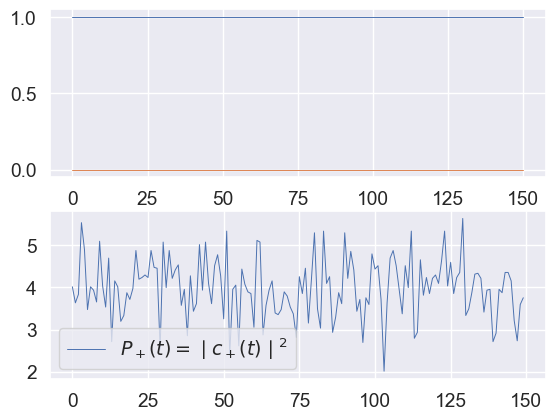

In [12]:
fig, ax = plt.subplots(2)

#ax[0].plot(t_span,-0.5*(np.sin(0.1*t_span))**2)

for i in range(1):
    ax[0].plot(t_span,abs(a_ensembe_strong[i])**2,linewidth=0.7,label = fr'$P_+(t)=\mid c_+(t)\mid^2$')
    ax[0].plot(t_span,abs(b_ensembe_strong[i])**2,linewidth=0.7,label = fr'$P_+(t)=\mid c_+(t)\mid^2$')
    ax[1].plot(t_span[:-1],X_ensembe_strong[i],linewidth=0.7,label = fr'$P_+(t)=\mid c_+(t)\mid^2$')

#for i in a_ensembe_strong[:10]: ax[0].plot(t_span,i**2,color='steelblue',linewidth=0.7)

#Create nice legend to show g, epsilon, Hamilton, delta_t, characteristic collapse time (and rabi frquency?)

#ax[1].plot(t_span,Pb_ensembe_strong_mean,label = r'$\langle P_-(t) \rangle$')
plt.legend();
#ax[0].set_ylim(0,1)
plt.show()

C:\Users\kts661\AppData\Local\Temp\ipykernel_26788\3774748653.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[1].legend()
C:\Users\kts661\AppData\Local\Temp\ipykernel_26788\3774748653.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[2].legend()


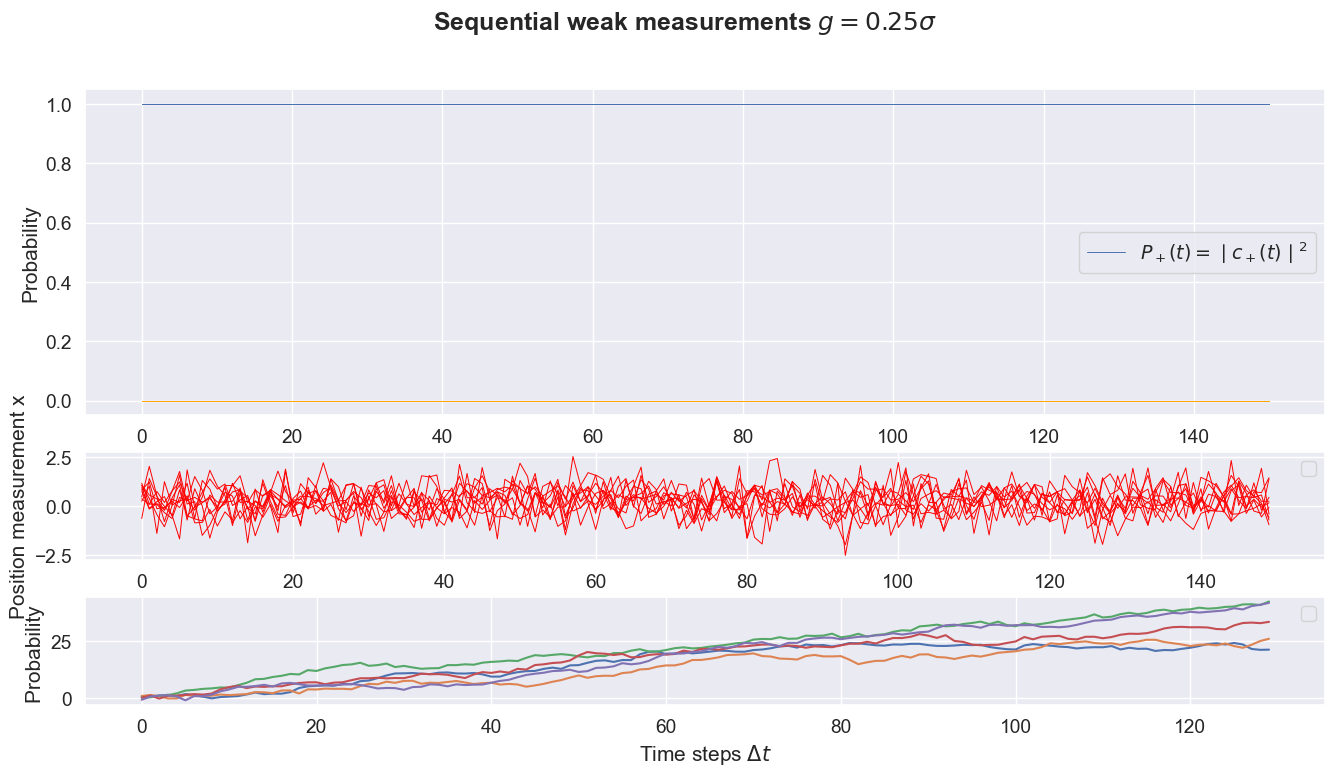

In [17]:
fig, ax = plt.subplots(3,gridspec_kw={'height_ratios': [3,1,1]},figsize=(16,8))

plt.suptitle(fr'Sequential weak measurements $g={gweak/sigma}\sigma$', fontsize=18,fontweight="bold")


ax[0].set_ylabel(r'Probability')


ax[1].set_ylabel(r'Position measurement x')

ax[2].set_xlabel(r"Time steps $\Delta t$");
ax[2].set_ylabel(r'Probability ')

for a in a_ensembe_weak: ax[0].plot(t_span,abs(a)**2,color='steelblue',linewidth=0.7)
for b in b_ensembe_weak: ax[0].plot(t_span,abs(b)**2,color='orange',linewidth=0.7)
#for i in a_ensembe_strong: ax[0,0].plot(t_span,i,color = 'green',linewidth=0.7)
#for i in a_ensembe_strong: ax[0,0].plot(t_span,i,color = 'green',linewidth=0.7)

ax[0].plot(t_span,abs(a_ensembe_weak[10])**2,linewidth=0.7,label = fr'$P_+(t)=\mid c_+(t)\mid^2$')
#ax[0,0].plot(t_span,a_ensembe_strong[10],color = 'green',linewidth=0.7,label = f'Strong measurement experiments g={gstrong}')

#plt.legend(loc='upper center', fancybox=True, shadow=True, ncol=2)

for x in X_ensembe_weak[:10]: 
    ax[1].plot(t_span[:-1],x,color='red',linewidth=0.7)
#for i in X_ensembe_strong[:-1]: ax[1,0].plot(t_span[:-1],i,color = 'green',linewidth=0.7)

for i in range(5): 
    ax[2].plot(t_span[:130],np.cumsum(X_ensembe_weak[i,:130]).T)

ax[0].legend()
ax[1].legend()
ax[2].legend()

#ax[0].set_ylim(0,1)


plt.show()
#print(fr'$\sigma$ =%.2f'%(sigma))

#fig.savefig(f'figures/gweak{gweak}sigma_Nsim{N_sim}.pdf')

**What did we learn from these plots:** If the average the two weights for each time step, we will erase the information of what state we are in. We are unable to distinc the two gaussian distributions that are shifted from one another. We therefore want to look at the accumulated time instead for long term memory...   

plot the change of $a$ and $b$ density functions over time

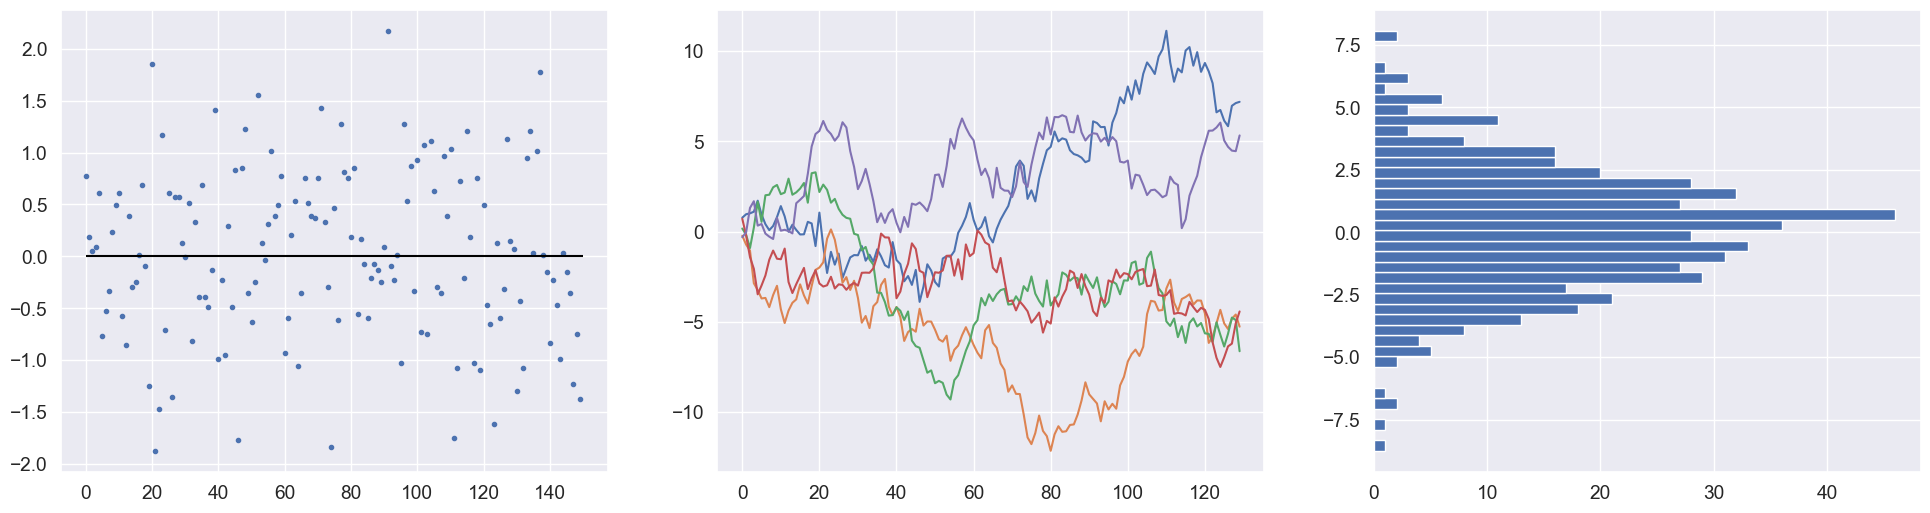

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(24,6))

ax[2].hist(X_ensembe_weak[:,:10].sum(axis=1),bins=40,orientation='horizontal')

ax[0].plot(t_span[:-1], X_ensembe_weak[0], '.')
ax[0].hlines(exp_x_weak,0,N,'black')

for i in range(5): 
    ax[1].plot(t_span[:130],np.cumsum(X_ensembe_weak[i,:130]).T)



plt.show()

(array([ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  3.,  8.,  5.,  5., 16., 20.,
        29., 24., 29., 45., 49., 57., 40., 37., 37., 29., 21.,  5.,  8.,
        15.,  6.,  3.,  0.,  1.,  2.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
         1.]),
 array([-12.05205205, -11.38888889, -10.72572573, -10.06256256,
         -9.3993994 ,  -8.73623624,  -8.07307307,  -7.40990991,
         -6.74674675,  -6.08358358,  -5.42042042,  -4.75725726,
         -4.09409409,  -3.43093093,  -2.76776777,  -2.1046046 ,
         -1.44144144,  -0.77827828,  -0.11511512,   0.54804805,
          1.21121121,   1.87437437,   2.53753754,   3.2007007 ,
          3.86386386,   4.52702703,   5.19019019,   5.85335335,
          6.51651652,   7.17967968,   7.84284284,   8.50600601,
          9.16916917,   9.83233233,  10.4954955 ,  11.15865866,
         11.82182182,  12.48498498,  13.14814815,  13.81131131,
         14.47447447]),
 <BarContainer object of 40 artists>)

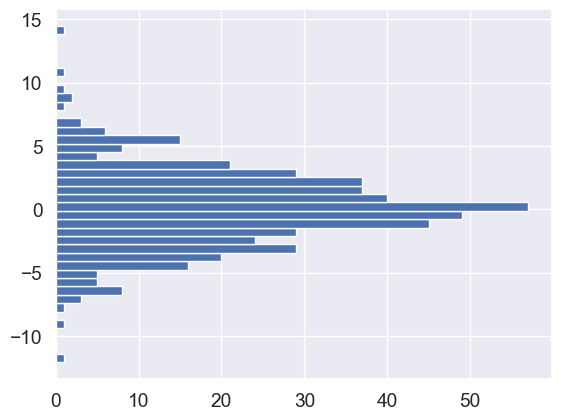

In [ ]:
plt.hist(X_ensembe_weak[:,:16].sum(axis=1),bins=40,orientation='horizontal')

Bredden af gauss er prop med sqrt(N)(antal målinger), afstand ml målingerne er prop med N. 

Tag X postion for enkelt måling og forudse om tilstanden er 0 eller 1. lav supervised learning ved at feede med  x positioner hvor vi ved tilstanden er 0 (go derefter med 1)

MovieWriter ffmpeg unavailable; using Pillow instead.
c:\Users\kts661\AppData\Local\miniconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


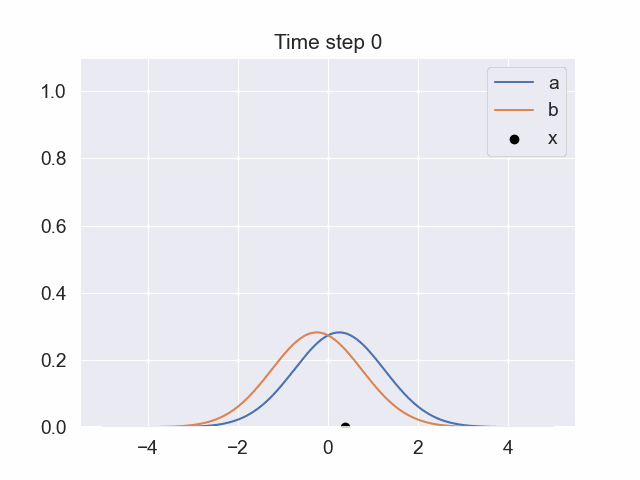

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import Image

sim = np.random.randint(0,N_sim)
X_span = np.linspace(-5,5,250)

fig, ax = plt.subplots()
line1, = ax.plot(X_span, a0*phi(X_span-gweak), label = 'a')
line2, = ax.plot(X_span, b0*phi(X_span+gweak), label = 'b')
point = ax.scatter(X_ensembe_weak[sim,0],0,color = 'black', label = 'x')

plt.legend()
ax.set_ylim(0,1.1)

def animate(i):
    a = a_ensembe_weak[sim,i]
    b = b_ensembe_weak[sim,i]
    line1.set_ydata(a*phi(X_span-gweak))
    line2.set_ydata(b*phi(X_span+gweak))
    point.set_offsets([X_ensembe_weak[sim,i],0])
    ax.set_title(f"Time step {i}")

    return (line1, line2, point),



ani = FuncAnimation(fig = fig,func = animate, frames=np.arange(80), interval=1)
ani.save("movie.gif")
plt.close()

display(Image(data=open('movie.gif','rb').read(), format='png'))



c:\Users\kts661\AppData\Local\miniconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)


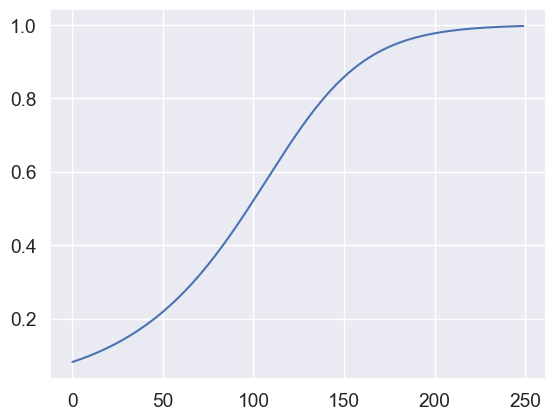

In [ ]:

plt.plot(cplus_VN(X_span,gweak,a0,b0))

### True and realisable quantum trajectories

In the simluation above, we draw measurement record from the knowlegde of the current state $(a,b)$ coefficients, and then we can update the state, and repeat. But in real experiements, we only have the measurement output and not any running state lists! So here, we will try to use the measurement record to create other possible system states and compare with the original "true" that the data is drawn from... The question is whether we can actually tell the different realisations apart? 

We have a measurement record, N_sim values for each time step and we find the i'th

* Time step $t_j = t_{j-1}+\Delta t$
* We draw a value a_i from cplus(x_i,gweak,a0,b0) BUT we do not know the first state.... we might need to assume a given state to get started? The initial state (a0,b0) will shift the two functions to the side... 

* Position measurement $x_i$ taken from the distribution $P(x,a_{i-1},b_{i-1})$. We add a Weiner process from a gausian - might not be important since we already draw x from a gaussian, but it might give a nice way to learn how to include other noise?
* Post measurement state, by updating the coeficitens $$\ket{\psi_{j+1}}= \frac{\Omega_x \ket{\psi_j}}{\mid \mid \Omega_x \ket{\psi_j} \mid \mid}$$

Which ultimately will give us 3 lists $\{x_i\}, \{a_i\}, \{b_i\}$ through a time evolution t. 

In [ ]:
a0,b0

(np.complex128(0.7071067811865475+0j), np.float64(0.7071067811865476))

ValueError: Expected 2D array, got 1D array instead:
array=[ 7.10710711e+00 -8.04804805e+00 -2.70270270e+00 -2.30230230e+00
  3.82382382e+00 -4.38438438e+00  4.96496496e+00 -5.94594595e+00
 -7.94794795e+00 -2.98298298e+00 -1.20120120e+00  1.13113113e+01
 -1.14714715e+01 -2.08208208e+00 -2.60260260e+00  9.36936937e+00
  6.50650651e+00 -1.50150150e+00 -2.64264264e+00  5.56556557e+00
 -4.60460460e+00 -1.02502503e+01  2.10210210e+00 -4.56456456e+00
 -4.22422422e+00  9.12912913e+00 -8.70870871e+00 -1.96196196e+00
 -6.64664665e+00 -6.16616617e+00 -3.72372372e+00  6.84684685e+00
 -1.06106106e+00  1.50150150e+00 -1.20120120e-01  3.34334334e+00
 -6.14614615e+00 -9.82982983e+00  9.78978979e+00  1.46146146e+00
  3.52352352e+00  1.43743744e+01  2.20220220e-01  7.70770771e+00
  1.80180180e-01 -1.48148148e+01  2.40240240e+00 -5.44544545e+00
  1.04104104e+00 -3.96396396e+00 -2.34234234e+00  4.42442442e+00
  4.52452452e+00 -1.18918919e+01  6.40640641e-01  4.10410410e+00
 -6.38638639e+00  1.28328328e+01  5.82582583e+00  5.12512513e+00
  7.56756757e+00  4.36436436e+00 -1.16116116e+00  7.62762763e+00
 -3.94394394e+00 -8.36836837e+00  1.49149149e+01 -2.06206206e+00
  1.03503504e+01  7.72772773e+00 -4.80480480e+00 -2.50250250e+00
  1.62762763e+01  4.62462462e+00  1.28128128e+00 -9.62962963e+00
 -9.64964965e+00 -2.66266266e+00 -2.56256256e+00 -2.14214214e+00
  3.92392392e+00 -5.36536537e+00  5.14514515e+00  4.04404404e+00
  3.10310310e+00 -3.40340340e-01  1.32532533e+01 -7.42742743e+00
 -8.94894895e+00  2.98298298e+00 -1.98198198e+00 -4.24424424e+00
  2.54254254e+00  5.00500501e-01 -6.32632633e+00  1.22922923e+01
  9.40940941e+00 -1.30330330e+01  3.24324324e+00  2.84284284e+00
  1.54154154e+00 -1.83583584e+01 -2.84284284e+00  4.58458458e+00
  8.80880881e-01  4.82482482e+00  2.98298298e+00  1.11911912e+01
  7.14714715e+00  9.94994995e+00  6.04604605e+00 -8.28828829e+00
 -9.06906907e+00 -4.50450450e+00 -9.82982983e+00 -1.30330330e+01
 -8.38838839e+00  3.40340340e-01  9.64964965e+00 -9.82982983e+00
  3.32332332e+00  7.22722723e+00  1.08108108e+01  1.62162162e+00
  3.18318318e+00  5.42542543e+00  3.06306306e+00  2.14214214e+00
 -7.68768769e+00 -2.00200200e+00 -1.43743744e+01 -1.58358358e+01
  1.43943944e+01  7.46746747e+00 -2.38238238e+00  4.94494494e+00
 -1.12112112e+00  4.70470470e+00  1.01301301e+01 -4.28428428e+00
 -4.20420420e+00 -1.61161161e+01 -1.16116116e+00  7.06706707e+00
  6.52652653e+00  8.60860861e-01  8.36836837e+00  4.04404404e+00
  7.48748749e+00 -4.16416416e+00 -2.64264264e+00  5.16516517e+00
 -2.40240240e+00  1.07907908e+01 -1.15515516e+01  3.56356356e+00
 -2.10210210e+00  4.06406406e+00  6.28628629e+00  5.56556557e+00
  6.28628629e+00 -6.52652653e+00  1.10110110e+00  3.42342342e+00
 -9.74974975e+00 -3.34334334e+00  1.45345345e+01  2.20220220e-01
  4.00400400e+00 -6.58658659e+00 -9.06906907e+00  1.40140140e-01
 -6.62662663e+00 -2.66266266e+00 -1.48148148e+00 -9.48948949e+00
 -1.11311311e+01 -3.80380380e+00  1.46146146e+00  7.18718719e+00
  3.62362362e+00  7.70770771e+00  1.36136136e+00  5.46546547e+00
  5.70570571e+00  2.45045045e+01  1.48148148e+00 -2.10210210e+00
  2.04204204e+00 -7.40740741e+00 -8.50850851e+00  6.04604605e+00
 -8.32832833e+00  5.02502503e+00  1.38138138e+00 -8.00800801e-01
  3.58358358e+00  2.32232232e+00  8.00800801e+00 -1.41941942e+01
  5.48548549e+00  2.16216216e+00  1.58158158e+00  8.00800801e-02
 -6.42642643e+00  3.68368368e+00 -1.14714715e+01 -1.69969970e+01
 -1.24524525e+01  8.06806807e+00  1.44144144e+00 -7.16716717e+00
 -1.36336336e+01  1.00100100e-01 -3.26326326e+00  7.68768769e+00
  2.36236236e+00  4.60460460e+00 -9.60960961e-01  1.00100100e+00
 -4.72472472e+00  3.96396396e+00  2.76276276e+00 -7.20720721e-01
  5.36536537e+00  8.54854855e+00 -1.06106106e+00  2.22222222e+00
  8.60860861e-01  4.78478478e+00  3.20320320e-01  1.49549550e+01
 -8.02802803e+00 -1.12112112e+00 -8.40840841e-01 -4.30430430e+00
  5.60560561e-01  5.74574575e+00 -1.25925926e+01 -4.24424424e+00
 -1.17117117e+01 -3.74374374e+00 -4.34434434e+00  1.13313313e+01
 -6.68668669e+00 -3.02302302e+00  1.07107107e+01 -8.00800801e-02
 -1.41941942e+01 -4.90490490e+00  1.26126126e+00  5.60560561e-01
  7.72772773e+00  8.12812813e+00 -5.62562563e+00  3.00300300e-01
 -5.04504505e+00  4.76476476e+00  1.21921922e+01  1.72172172e+00
 -9.56956957e+00 -6.00600601e-02  1.06106106e+01  9.74974975e+00
  9.20920921e-01 -9.52952953e+00 -7.80780781e-01 -1.63363363e+01
 -2.80280280e+00 -5.40540541e-01  7.34734735e+00 -1.14514515e+01
  1.12112112e+00 -2.03403403e+01 -1.74374374e+01 -1.60160160e+00
  4.80480480e-01 -1.30130130e+00 -8.40840841e-01  2.04204204e+00
 -8.26826827e+00  1.50550551e+01 -9.10910911e+00  9.48948949e+00
 -9.22922923e+00 -1.59759760e+01  3.02302302e+00  4.96496496e+00
  4.12412412e+00 -5.38538539e+00  8.56856857e+00 -2.90290290e+00
 -6.72672673e+00 -1.60760761e+01  6.72672673e+00  2.56256256e+00
 -5.12512513e+00  1.34334334e+01 -6.12612613e+00 -8.88178420e-16
 -1.94194194e+00  1.84184184e+00  5.16516517e+00  2.40240240e-01
  1.34334334e+01  3.62362362e+00 -2.88288288e+00 -2.60260260e-01
 -9.94994995e+00  7.68768769e+00 -6.76676677e+00 -2.86286286e+00
  7.80780781e+00 -7.40740741e-01  6.00600601e+00  3.58358358e+00
  7.68768769e+00 -3.30330330e+00  7.84784785e+00  4.34434434e+00
  4.32432432e+00  1.70170170e+00 -9.90990991e+00  1.01301301e+01
 -1.46146146e+00  4.44444444e+00  1.49549550e+01 -1.87187187e+01
 -1.75175175e+01 -1.24724725e+01 -2.98298298e+00 -6.28628629e+00
  2.12212212e+00 -1.20120120e+00  2.32232232e+00  2.02202202e+00
 -1.02902903e+01  1.21321321e+01 -2.30230230e+00 -1.01101101e+01
 -3.40340340e+00  3.68368368e+00 -1.06106106e+00 -5.40540541e-01
 -1.88188188e+00  1.55955956e+01 -3.34334334e+00  7.56756757e+00
  7.20720721e-01  9.84984985e+00 -3.96396396e+00 -1.50150150e+00
  5.94594595e+00 -9.00900901e+00  1.10110110e+00 -7.30730731e+00
 -2.24224224e+00 -4.72472472e+00  6.02602603e+00  6.40640641e+00
  3.18318318e+00  1.30130130e+00 -2.78278278e+00 -4.20420420e-01
 -9.64964965e+00  4.88488488e+00  8.00800801e-02  6.92692693e+00
 -8.36836837e+00 -4.58458458e+00 -4.60460460e-01  1.28728729e+01
  2.40240240e-01 -2.46246246e+00 -1.29929930e+01 -4.38438438e+00
 -3.48348348e+00 -1.24524525e+01 -5.84584585e+00 -9.00900901e-01
  2.00200200e+00  1.60160160e-01 -1.62162162e+00  2.40240240e+00
 -1.04104104e+00 -3.20320320e-01 -5.40540541e-01  8.80880881e-01
  7.50750751e+00  3.48348348e+00 -9.08908909e+00  4.02402402e+00
  1.49349349e+01  1.72172172e+00 -7.60760761e-01  1.34134134e+01
  5.28528529e+00 -4.52452452e+00  3.16316316e+00 -8.20820821e-01
 -4.50450450e+00 -1.21921922e+01  4.50450450e+00  6.26626627e+00
  1.92192192e+00  5.08508509e+00  1.26126126e+00 -6.56656657e+00
 -6.10610611e+00 -1.20120120e+01 -2.52252252e+00  7.18718719e+00
 -1.15715716e+01 -5.00500501e+00 -8.12812813e+00  1.14114114e+00
  1.59759760e+01 -9.54954955e+00  1.12512513e+01  2.20220220e-01
 -2.16216216e+00 -4.54454454e+00 -7.02702703e+00 -2.48248248e+00
 -1.56156156e+00 -1.69169169e+01  1.55955956e+01 -3.22322322e+00
  2.32232232e+00 -1.42542543e+01  7.70770771e+00  5.66566567e+00
  3.18318318e+00  1.04904905e+01  2.00200200e-01 -1.60160160e-01
  6.20620621e-01  3.70370370e+00 -4.18418418e+00  1.57957958e+01
  1.24324324e+01  1.04704705e+01  6.64664665e+00 -9.00900901e+00
  1.50350350e+01  6.06606607e+00 -2.88288288e+00 -5.84584585e+00
  9.96996997e+00  3.60360360e+00 -1.23523524e+01  2.88288288e+00
  1.02502503e+01  1.22522523e+01 -3.70370370e+00  2.72272272e+00
 -1.22322322e+01 -3.40340340e-01 -8.30830831e+00  7.14714715e+00
 -3.34334334e+00 -5.96596597e+00  4.20420420e+00  1.92192192e+00
  1.21321321e+01 -9.00900901e+00 -1.68168168e+00  5.48548549e+00
  1.01901902e+01  3.18318318e+00 -6.36636637e+00  4.88488488e+00
  7.18718719e+00 -8.36836837e+00 -2.84284284e+00  4.06406406e+00
 -1.05305305e+01  5.64564565e+00  2.62262262e+00 -6.02602603e+00
  4.54454454e+00 -1.27527528e+01 -1.48148148e+00 -3.92392392e+00
  5.28528529e+00  1.78178178e+00  9.38938939e+00  8.40840841e+00
 -1.04504505e+01 -2.06206206e+00  2.20220220e-01  6.62662663e+00
 -3.32332332e+00  3.16316316e+00 -1.02702703e+01 -2.44244244e+00
 -3.28328328e+00  7.30730731e+00  4.64464464e+00  1.30130130e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

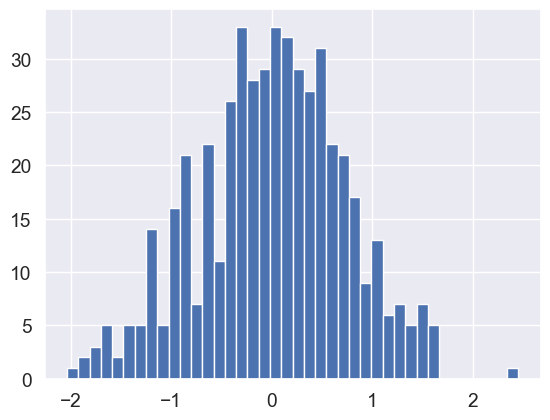

In [ ]:
from sklearn.mixture import GaussianMixture


plt.hist(X_ensembe_weak[:,:100].sum(axis=1)/10,bins=40)


gm = GaussianMixture(n_components=2, random_state=0).fit(X_ensembe_weak[:,:100].sum(axis=1))


plt.plot(X_span,N_sim*p(X_span,2.5,a0,b0))

plt.xlim(-8, 8)



In [ ]:
plt.hist(X_ensembe_weak[:,0],bins=30)
plt.plot(X_span,N_sim*p(X_span,0.01,a0,b0))

plt.xlim(-3, 3)


plt.show()

In [ ]:
len(X_ensembe_weak[0,:])

In [ ]:
def Realisable_sim(X,a0,b0,gweak)
    '''With measurement record X with N measurements and N_sim realisations, compute a (single?) possible quantum trajectory'''
    N = len(X_ensembe_weak[0,:]) #Number of measurement on single 
    N_sim = len

    af = np.zeros((N_sim, N+1)) #coeficitent in plus state
    bf = np.zeros((N_sim, N+1)) #coeficitent in minus state  

    #Initial conditions
    a[:,0] = np.repeat(a0,N_sim)
    b[:,0] = np.repeat(b0,N_sim)

    for i in range(N):#creating N_sim number of quantum trajectory in parallel
        P = p(X_span,g,a[:,i],b[:,i]) 
        P = P/P.sum(axis=1)[:,None]
        X[:, i] = np.array([np.random.choice(X_span,p=P[i,:]) for i in range(N_sim)])#Collect position measurement from the previus state, do not depend directly on the prevues position measurement!
        k = np.random.uniform(0,1) 
        if 0<k<r*delta_t:#bitflip!
            a[:,i+1] =  cminus_VN(X[:,i],g,a[:,i],b[:,i])
            b[:,i+1] = cplus_VN(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
        else:
            a[:,i+1] = cplus_VN(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
            b[:,i+1] = cminus_VN(X[:,i],g,a[:,i],b[:,i])
    return X,a,b

'''
def Xeuler_sim(N_sim, N, g, a0=1/np.sqrt(2) ,b0=None,r=0, delta_t=1):#

    Random walk with fixed step size, in a neaumann system. Can run multiple simulations at once.

    Input:
    N_sim: number of simulations
    N: number of measurements per simulation
    g: interaction strength
    a0: initial state coefficient plus
    b0: initial state coefficient minus
    r: rate for bit flip 

    Output:
    X: array with the particle position measurement at different time steps - measurement record.
    a: array with the particle state coefficient plus at different time steps.
    b: array with the particle state coefficient minus at different time steps.

    if b0 is None:
        b0 = np.sqrt(1 - a0**2)
        
    
    assert a0**2 + b0**2 == 1, 'Initial state coefficients do not sum to 1'
        
    
    X_span = np.linspace(-10,10,1000)
    
    X = np.zeros((N_sim, N)) #spot to plug in new position, one less measurement than states (starts and ends with states
    a = np.zeros((N_sim, N+1)) #coeficitent in plus state
    b = np.zeros((N_sim, N+1)) #coeficitent in minus state

    #Initial conditions
    a[:,0] = np.repeat(a0,N_sim)
    b[:,0] = np.repeat(b0,N_sim)

#    X[0] = #np.random.choice(X_span,p=p(X_span,gstrong,a[0],b[0])/p(X_span,gstrong,a[0],b[0]).sum()) #First measurement
    for i in range(N):#creating N_sim number of quantum trajectory in parallel
        P = p(X_span,g,a[:,i],b[:,i]) 
        P = P/P.sum(axis=1)[:,None]
        X[:, i] = np.array([np.random.choice(X_span,p=P[i,:]) for i in range(N_sim)])#Collect position measurement from the previus state, do not depend directly on the prevues position measurement!
        k = np.random.uniform(0,1) 
        if 0<k<r*delta_t:#bitflip!
            a[:,i+1] =  cminus_VN(X[:,i],g,a[:,i],b[:,i])
            b[:,i+1] = cplus_VN(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
        else:
            a[:,i+1] = cplus_VN(X[:,i],g, a[:,i],b[:,i]) #Depends on initial state but next. Can it be complex from time evolution)?
            b[:,i+1] = cminus_VN(X[:,i],g,a[:,i],b[:,i])
    return X,a,b
'''

In [ ]:
plt.hist(X_ensembe_weak[:].sum(axis=1),bins=40)
#plt.plot(X_span,a0*phi(X_span-gweak))
plt.show()